In [35]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import matplotlib.pyplot as plt
import sys
import torch
from neutromeratio.parameter_gradients import FreeEnergyCalculator
from neutromeratio.constants import kT, device, hartree_to_kJ_mol
import torchani
import nglview
from tqdm import tqdm

In [2]:
dcd = '/home/mwieder/watercluster-80-bottom-restraints-10.6/watercluster-80-bottom-restraints-10.6.dcd'
pdb = '/home/mwieder/watercluster-80-bottom-restraints-10.6/watercluster-80-bottom-restraints-10.6.pdb'

In [3]:
mdtraj = md.load_dcd(dcd, top=pdb)

In [4]:
v = neutromeratio.generate_nglview_object(mdtraj) 
v.shape.add_sphere([0, 0.0, 0], [0,0,1], (21.2)/2)
v.update_representation(component=1, repr_index=0, opacity=0.2)
v

NGLWidget(max_frame=50000)

In [5]:
atoms = [a.element.symbol for a in mdtraj.topology.atoms]
model = torchani.models.ANI1ccx()

energy_function = neutromeratio.ANI1_force_and_energy(model = model,
                                          atoms = atoms,
                                          mol = None,
                                          use_pure_ani1ccx=True)




n_models = energy_function.model.ensemble_size

xyz_in_angstroms = mdtraj.xyz * 10
coordinates = torch.tensor(xyz_in_angstroms)
n_snapshots = len(coordinates)

species = energy_function.species


In [50]:
atoms = [a.element.symbol for a in mdtraj.topology.atoms]
model = torchani.models.ANI1ccx()

energy_function = neutromeratio.ANI1_force_and_energy(model = model,
                                          atoms = atoms,
                                          mol = None,
                                          use_pure_ani1ccx=True)




n_models = energy_function.model.ensemble_size

xyz_in_angstroms = mdtraj[::100].xyz * 10
coordinates = torch.tensor(xyz_in_angstroms)
n_snapshots = len(coordinates)

species = energy_function.species
species_list = species.tolist()[0]
n_atoms = len(species_list)
mod_species = torch.stack([species[0]] * len(coordinates))

print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))

print('species.shape', mod_species.shape)
print('coordinates.shape', coordinates.shape)
_, aevs = model.aev_computer((mod_species, coordinates))

raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
for i in tqdm(range(n_atoms)):
    for j in range(n_models):
        raw_energies[:, i, j] = model.neural_networks[j][species_list[i]].forward(
            aevs[:, i, :]).detach().flatten() * hartree_to_kJ_mol


n_snapshots: 501, n_atoms: 240, n_models: 8
species.shape torch.Size([501, 240])
coordinates.shape torch.Size([501, 240, 3])


100%|██████████| 240/240 [00:06<00:00, 35.37it/s]


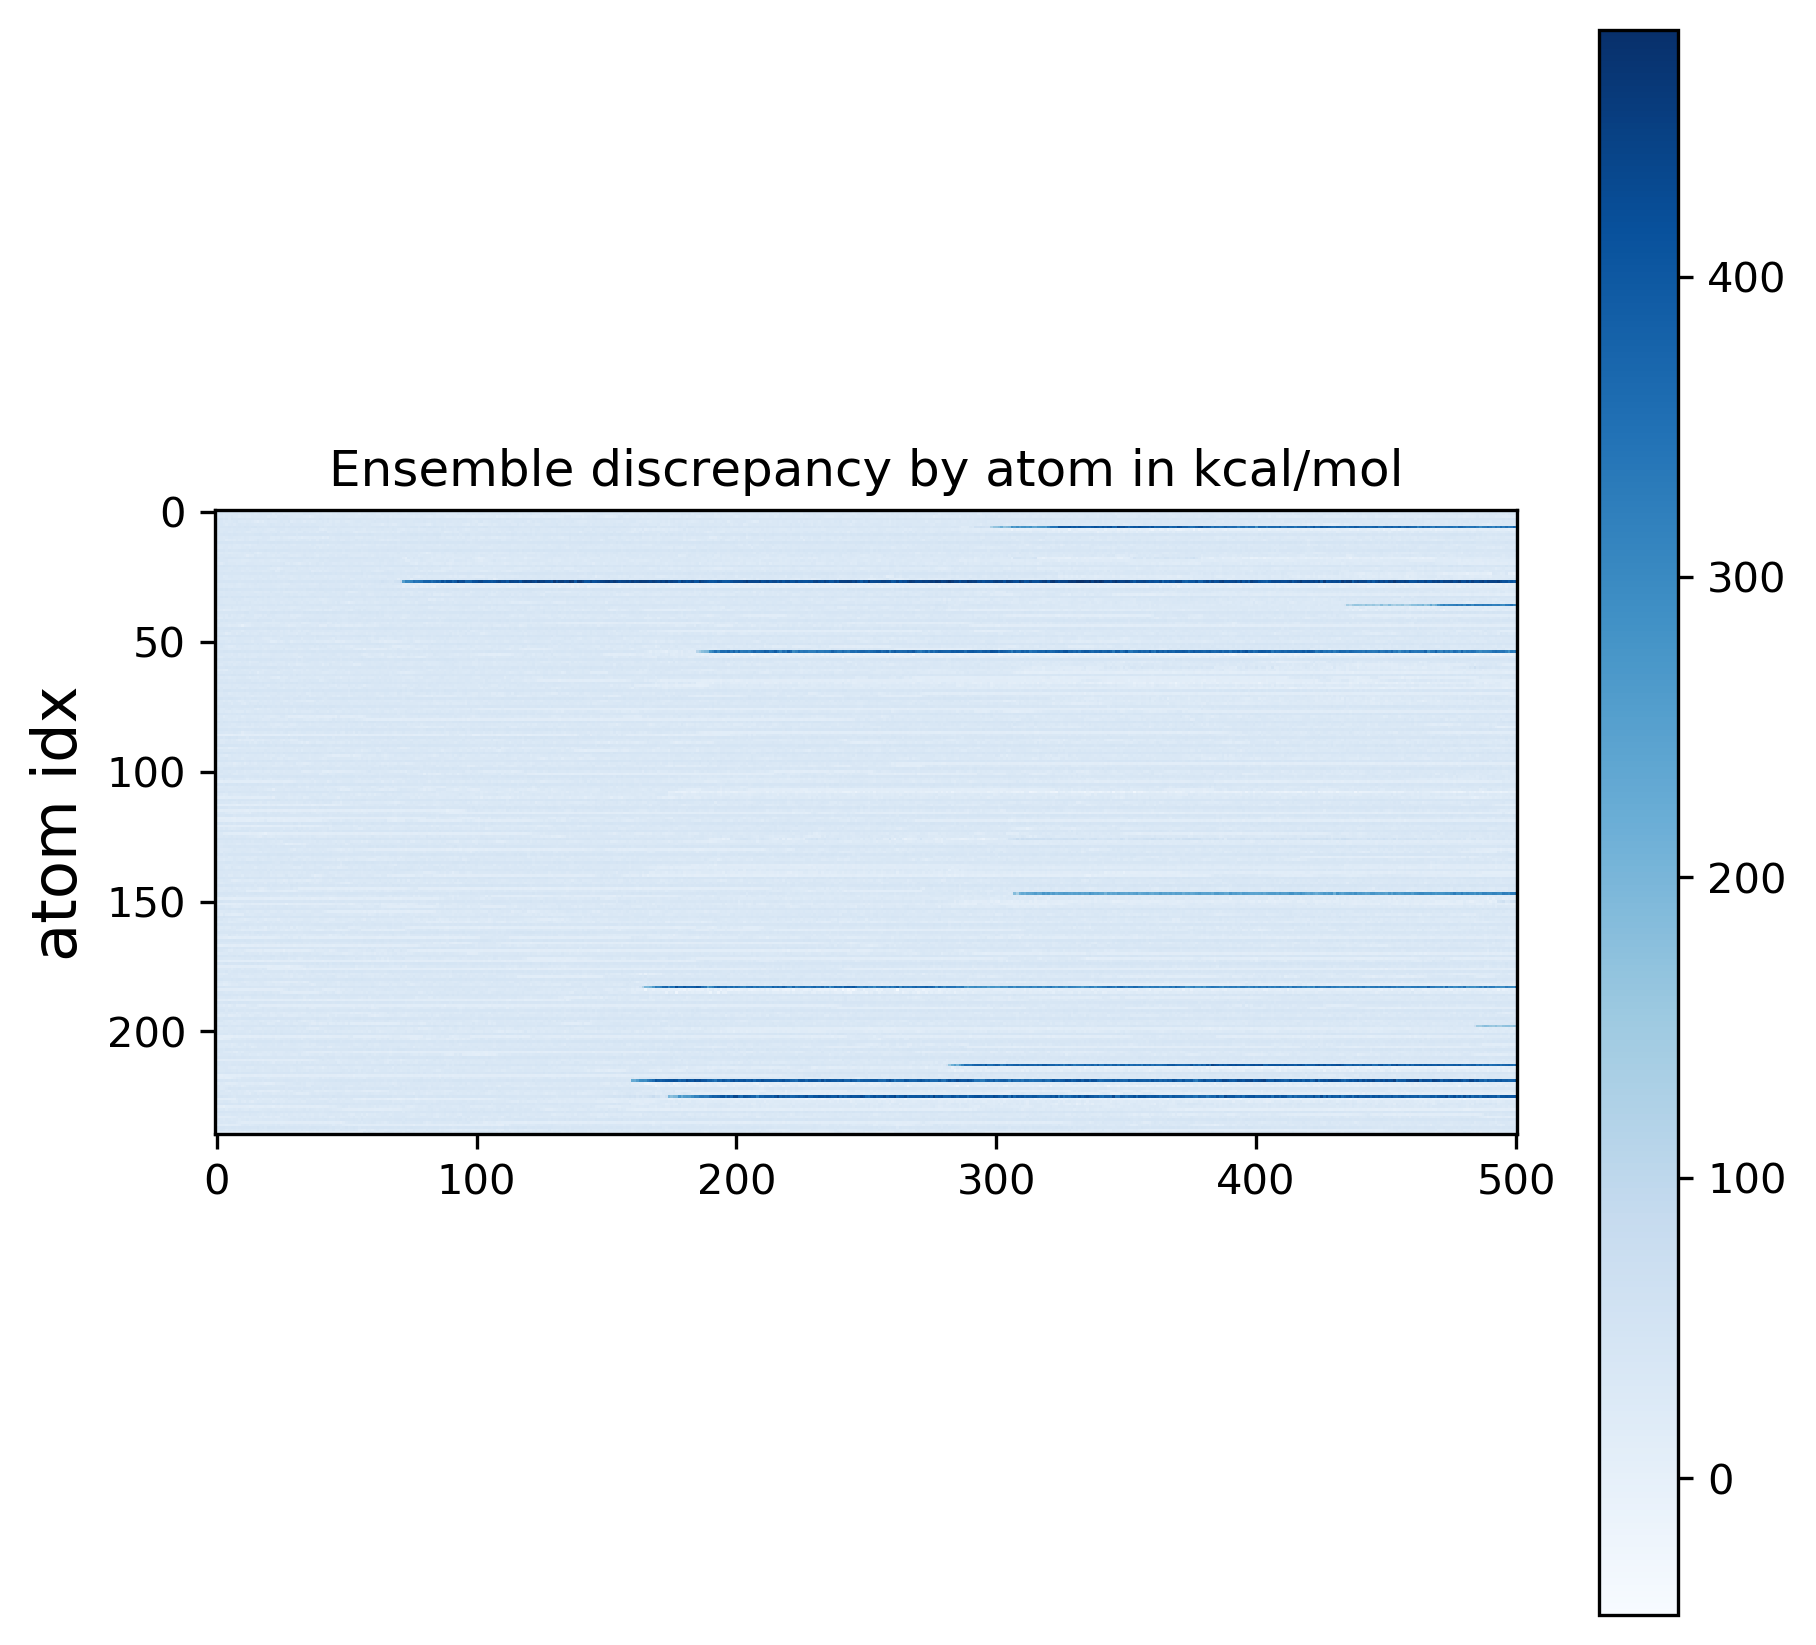

In [42]:
fig = plt.figure(figsize=[7,7], dpi=300)
fontsize=15

pos = plt.imshow(-np.mean(raw_energies, axis=2).transpose(), cmap='Blues')
plt.title('Ensemble discrepancy by atom in kcal/mol')
plt.ylabel('MD snapshost', size=fontsize)
plt.ylabel('atom idx', size=fontsize)
plt.colorbar(pos)
plt.show()

In [59]:
bad_inds = []
m = np.mean(raw_energies, axis=2).transpose()
for idx in range(n_atoms):
    if any(e  < -100 for e in list(m[idx])):
        bad_inds.append(idx)

In [52]:
def plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=True):
    """raw_energies is an array of shape (n_snapshots, n_atoms, n_models), assumed in hartree
    bad_inds is an integer array of atom indices that we want to color -- all other atoms will be grey
    """
    plt.plot(
        (raw_energies.mean(-1) - raw_energies.mean(-1)[0]),
    c='grey', alpha=0.1)


    mean = (raw_energies.mean(-1)[:,bad_inds] - raw_energies.mean(-1)[0,bad_inds]) 
    stddev = (raw_energies).std(-1)[:,bad_inds]
    for i in range(len(bad_inds)):
        plt.plot(np.arange(len(raw_energies)), mean[:,i])
        if plot_uncertainty_band:
            plt.fill_between(np.arange(len(raw_energies)),
                         mean[:,i] - stddev[:,i], mean[:,i] + stddev[:,i], alpha=0.1)


    plt.ylabel('atomic contribution to total energy (kJ/mol)\n(centered at contribution at $t=0$)')
    plt.xlabel('MD snapshot')
    start_of_sentence = 'each oxygen that switches into spurious geometry'
    end_of_sentence = 'contributes very favorably to the total energy'
    if plot_uncertainty_band:
        end_of_sentence = 'is highly "controversial"'
    plt.title('{}\n{}'.format(start_of_sentence, end_of_sentence))

    plt.tight_layout()
    


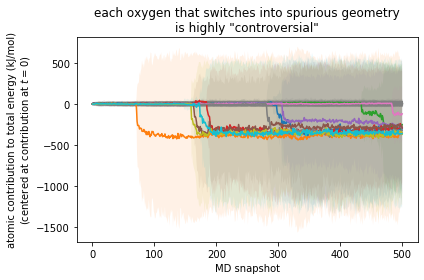

In [60]:
plot_energy_contributions(raw_energies, bad_inds=bad_inds)

In [ ]:
atoms = [a.element.symbol for a in mdtraj.topology.atoms]

In [ ]:
atoms = [a.element.symbol for a in mdtraj.topology.atoms]
model = torchani.models.ANI1ccx()

energy_function = neutromeratio.ANI1_force_and_energy(model = model,
                                          atoms = atoms,
                                          mol = None,
                                          use_pure_ani1ccx=True)




In [ ]:
from openmmtools.testsystems import WaterCluster
from neutromeratio.restraints import FlatBottomRestraintToCenter, FlatBottomRestraint
nr_of_waters = 25
w = WaterCluster(n_waters=nr_of_waters)

center = np.array([0.,0.,0.]) * unit.angstrom
r = 10.2 * unit.angstrom



#os.makedirs(f"{base_path}/{name}", exist_ok=True)

# set FlattBottomRestraintToCenter restraints
solvent_restraints = []
for residue in w.mdtraj_topology.residues:   
    if residue.is_water:
        for atom in residue.atoms:
            if str(atom.element.symbol) == 'O':
                solvent_restraints.append(
                    FlatBottomRestraintToCenter(sigma=0.1 * unit.angstrom, 
                                                point=center, 
                                                radius=r,  
                                                atom_idx = atom.index, 
                                                active_at_lambda=-1))
                print('Adding restraint to center to {}'.format(atom.index))

for residue in w.mdtraj_topology.residues:   
    if residue.is_water:
        oxygen_idx = None
        hydrogen_idxs = []
        for atom in residue.atoms:
            if str(atom.element.symbol) == 'O':
                oxygen_idx = atom.index
            elif str(atom.element.symbol) == 'H':
                hydrogen_idxs.append(atom.index)
            else:
                raise RuntimeError('Water should only consist of O and H atoms.')
        solvent_restraints.append(FlatBottomRestraint(sigma=0.1 * unit.angstrom, atom_i_idx=oxygen_idx, atom_j_idx=hydrogen_idxs[0], atoms=atoms))
        solvent_restraints.append(FlatBottomRestraint(sigma=0.1 * unit.angstrom, atom_i_idx=oxygen_idx, atom_j_idx=hydrogen_idxs[1], atoms=atoms))


        

for r in solvent_restraints:
    energy_function.add_restraint(r)


In [ ]:
for xyz in mdtraj.xyz:
    xyz = xyz * unit.nanometer
    print(energy_function.calculate_energy(xyz))

In [ ]:
n_models = energy_function.model.ensemble_size

xyz_in_angstroms = mdtraj.xyz * 10
coordinates = torch.tensor(xyz_in_angstroms)
n_snapshots = len(coordinates)

species = energy_function.species

species_list = list(map(int, species))
n_atoms = len(species_list)

print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))

mod_coordinates = torch.cat((coordinates[:, :dummy_atom], coordinates[:, dummy_atom + 1:]), dim=1)
mod_species = torch.stack([mod_species[0]] * len(mod_coordinates))
print('mod_species.shape', mod_species.shape)
print('mod_coordinates.shape', mod_coordinates.shape)
_, mod_aevs = model.aev_computer((mod_species, mod_coordinates))

raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
for i in tqdm(range(n_atoms)):
    for j in range(n_models):
        raw_energies[:, i, j] = model.neural_networks[j][species_list[i]].forward(
            mod_aevs[:, i, :]).detach().flatten()
return raw_energies
